In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 5.2 MB/s 


# Loading Libraries

In [3]:
import re
import nltk
import time
import sqlite3

# To remove warn
import warnings 
warnings.filterwarnings('ignore')

# For data manupulation and visualization 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# For text Preprocessing 
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# For model applications
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestClassifier
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# For ANN model making 
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

# For model evaluation
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

**Import data from database**

In [4]:
con = sqlite3.connect("/content/drive/MyDrive/LexiconDataset/database.sqlite")
df = pd.read_sql_query("SELECT * from Reviews", con)
display(df.head())
con.close()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
# Here is the dataset shape
print("Loaded dataset shape:", df.shape)

Loaded dataset shape: (568454, 10)


**Convert using Columns into DataFrame**

In [6]:
# Extracting the text and Score columns
df = df[['Text', 'Score']]
df.head(10)

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5
5,I got a wild hair for taffy and ordered this f...,4
6,This saltwater taffy had great flavors and was...,5
7,This taffy is so good. It is very soft and ch...,5
8,Right now I'm mostly just sprouting this so my...,5
9,This is a very healthy dog food. Good for thei...,5


In [7]:
# Convert Score into postive and negative through function
def f(x):
    if x >3:
        return "positive"
    else:
        return "negative"
df['Score']=df.Score.apply(f)
df.head()

,Text,Score
0,I have bought several of the Vitality canned d...,positive
1,Product arrived labeled as Jumbo Salted Peanut...,negative
2,This is a confection that has been around a fe...,positive
3,If you are looking for the secret ingredient i...,negative
4,Great taffy at a great price. There was a wid...,positive


In [8]:
le = LabelEncoder()
df['Score'] = le.fit_transform(df['Score'])
df.head()

,Text,Score
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,1


# **preprocessing Text Data**

In [9]:
#Tokenization of text
tokenizer=ToktokTokenizer()

#Setting English stopwords
nltk.download('stopwords')
stopword_list=stopwords.words('english')

#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_special_characters(text)
    text = remove_stopwords(text)
    return text

#Apply function on review column
df['Text'] = df['Text'].apply(denoise_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Seperating the text and labels and splitting it into train and test data**

In [10]:
# Convert data into traning and testing part
x=df.iloc[:,0]
y=df.iloc[:,1]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)

In [11]:
# Apply CountVectorizer to convert Text data into numbers 
vectorizer = CountVectorizer(max_features=50)
x_train=vectorizer.fit_transform(x_train).toarray()
x_test=vectorizer.transform(x_test).toarray()
print(x_train.shape)
print(x_test.shape)

(397917, 50)
(170537, 50)


# **Apply Machine Learning Models**

In [12]:
# Function to evaluate Model
def evaluate_model(y_test, y_pred, model_Name):

  # Display Accuracy Score
  acc=accuracy_score(y_test,y_pred)
  print("accuracy of "+ model_Name + " is:" ,round(acc, 2) * 100)

  # Display Confusion Metrics
  print("Confusion Matrix:\n", confusion_matrix(y_test,y_pred))

  # Display Classification Report
  print("Classification Report:\n", classification_report(y_test,y_pred))

  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)

  # Confusion Matrix Graph of GB
  sns.heatmap(confusion_matrix(y_test,y_pred), annot=True).set(title=model_Name)

  return [acc, precision, recall]

In [13]:
def get_train_accuracy_evolution_graph(clf, x_train, x_test):
  accuracy_scores = []
  train_size = []

  for limit in [i for i in range(1000, x_train.shape[0], 20000)]:
    x_train_part = x_train[:limit]
    y_train_part = y_train[:limit]

    clf.fit(x_train_part,y_train_part)
    y_pred=clf.predict(x_test)

    acc=accuracy_score(y_test, y_pred)
    acc = round(acc, 2) * 100

    accuracy_scores.append(acc)
    train_size.append(limit)

  plt.plot(train_size, accuracy_scores, color='red')
  plt.scatter(train_size, accuracy_scores, color='blue')

**Gaussian Naive Bayes Classifier**

accuracy of Gaussian Naive Bayes is: 73.0
Confusion Matrix:
 [[ 11810  25628]
 [ 20196 112903]]
Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.32      0.34     37438
           1       0.82      0.85      0.83    133099

    accuracy                           0.73    170537
   macro avg       0.59      0.58      0.59    170537
weighted avg       0.72      0.73      0.72    170537



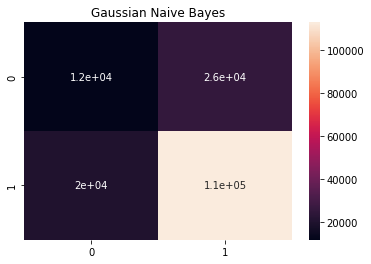

In [14]:
# Gaussin Navie-Bayes
clf= GaussianNB(var_smoothing=2e-9)
clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
gnb_result = evaluate_model(y_test, y_pred, "Gaussian Naive Bayes")

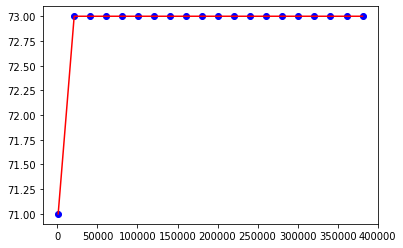

In [15]:
get_train_accuracy_evolution_graph(clf, x_train, x_test)

**Lexcion-Based Sentiment with Vader**

In [16]:
#Applying the Lexicon
analyzer = SentimentIntensityAnalyzer()

#Function For Sentiment Scores
def calculate_sentiment_scores(sentence):
    return analyzer.polarity_scores(sentence)['compound']

eng_snt_score =  []

for comment in df.Text.to_list():
    snts_score = calculate_sentiment_scores(comment)
    eng_snt_score.append(snts_score)

#Add Sentiment Score into DataFrame
df['sentiment_score'] = np.array(eng_snt_score)
df.head()

,Text,Score,sentiment_score
0,bought several Vitality canned dog food produc...,1,0.9413
1,Product arrived labeled Jumbo Salted Peanutsth...,0,-0.1027
2,confection around centuries light pillowy citr...,1,0.7926
3,looking secret ingredient Robitussin believe f...,0,0.4404
4,Great taffy great price wide assortment yummy ...,1,0.9468


In [17]:
#Fount Sentiment_Score labels into postive and Negative
i = 0
vader_sentiment = []
while(i<len(df)):
    if ((df.iloc[i]['sentiment_score'] >= 0.05)):
        vader_sentiment.append('positive')
        i = i+1
    else:
        vader_sentiment.append('negative')
        i = i+1

#Add label into DataFrame
df['vader_sentiment_labels'] = vader_sentiment
df.head()

,Text,Score,sentiment_score,vader_sentiment_labels
0,bought several Vitality canned dog food produc...,1,0.9413,positive
1,Product arrived labeled Jumbo Salted Peanutsth...,0,-0.1027,negative
2,confection around centuries light pillowy citr...,1,0.7926,positive
3,looking secret ingredient Robitussin believe f...,0,0.4404,positive
4,Great taffy great price wide assortment yummy ...,1,0.9468,positive


In [18]:
#Add to new column in DataFrame 
df['actual_label'] = df['Score'].copy()
df['predicted_label'] = df['vader_sentiment_labels'].map({'positive': 1, 'negative':0})
df.head()

,Text,Score,sentiment_score,vader_sentiment_labels,actual_label,predicted_label
0,bought several Vitality canned dog food produc...,1,0.9413,positive,1,1
1,Product arrived labeled Jumbo Salted Peanutsth...,0,-0.1027,negative,0,0
2,confection around centuries light pillowy citr...,1,0.7926,positive,1,1
3,looking secret ingredient Robitussin believe f...,0,0.4404,positive,0,1
4,Great taffy great price wide assortment yummy ...,1,0.9468,positive,1,1


accuracy of Lexicon Based Classifier is: 81.0
Confusion Matrix:
 [[ 35548  89129]
 [ 21208 422569]]
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.29      0.39    124677
           1       0.83      0.95      0.88    443777

    accuracy                           0.81    568454
   macro avg       0.73      0.62      0.64    568454
weighted avg       0.78      0.81      0.78    568454



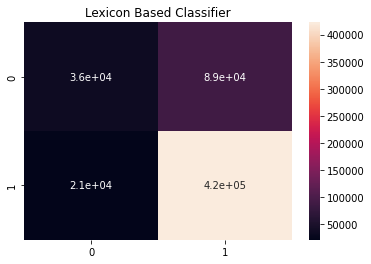

In [19]:
y_true = df['actual_label'].values
y_pred = df['predicted_label'].values
lbc_result = evaluate_model(y_true, y_pred, "Lexicon Based Classifier")

**Ensemble Models**
1. Random Forest Classifier
2. Ada Boost Classifier


accuracy of Random Forest Classifier is: 85.0
Confusion Matrix:
 [[ 16275  21163]
 [  5136 127963]]
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.43      0.55     37438
           1       0.86      0.96      0.91    133099

    accuracy                           0.85    170537
   macro avg       0.81      0.70      0.73    170537
weighted avg       0.84      0.85      0.83    170537



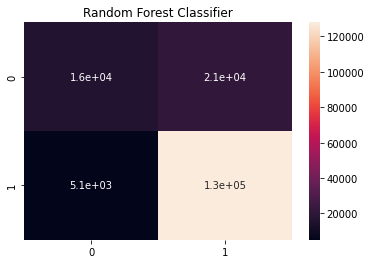

In [20]:
# Random Forest Classifier
rfc=RandomForestClassifier()
rfc.fit(x_train,y_train)
y_pred=rfc.predict(x_test)
rfc_result = evaluate_model(y_test, y_pred, "Random Forest Classifier")

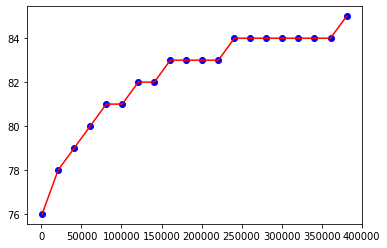

In [21]:
get_train_accuracy_evolution_graph(rfc, x_train, x_test)

accuracy of ADA Boost Classifier is: 78.0
Confusion Matrix:
 [[  4235  33203]
 [  3503 129596]]
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.11      0.19     37438
           1       0.80      0.97      0.88    133099

    accuracy                           0.78    170537
   macro avg       0.67      0.54      0.53    170537
weighted avg       0.74      0.78      0.72    170537



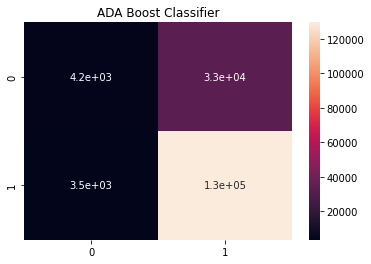

In [22]:
# Ada Boost Classifier
ada_model = AdaBoostClassifier()
ada_model.fit(x_train, y_train)
y_pred = ada_model.predict(x_test)
ada_result = evaluate_model(y_test, y_pred, "ADA Boost Classifier")

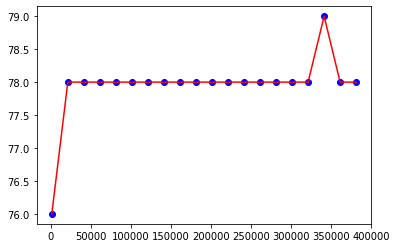

In [23]:
get_train_accuracy_evolution_graph(ada_model, x_train, x_test)

**Artifical Neural Network**

In [24]:
#initializing ANN model
ann_model = Sequential()

#add 1st hidden layer
ann_model.add(Dense(input_dim = x_train.shape[1], units = 128, kernel_initializer='uniform', activation='relu'))

#add output layer
ann_model.add(Dense(units = 2, kernel_initializer='uniform', activation='softmax'))

#compile the neural network
ann_model.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=['accuracy'])

#model summary
ann_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               6528      
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 6,786
Trainable params: 6,786
Non-trainable params: 0
_________________________________________________________________


In [25]:
#fit training dataset into the model
ann_model.fit(x_train, to_categorical(y_train), epochs=10)

Epoch 1/10
12435/12435 [==============================] - 32s 2ms/step - loss: 0.4640 - accuracy: 0.7896
Epoch 2/10
12435/12435 [==============================] - 29s 2ms/step - loss: 0.4551 - accuracy: 0.7928
Epoch 3/10
12435/12435 [==============================] - 29s 2ms/step - loss: 0.4510 - accuracy: 0.7946
Epoch 4/10
12435/12435 [==============================] - 30s 2ms/step - loss: 0.4482 - accuracy: 0.7958
Epoch 5/10
12435/12435 [==============================] - 29s 2ms/step - loss: 0.4455 - accuracy: 0.7972
Epoch 6/10
12435/12435 [==============================] - 29s 2ms/step - loss: 0.4433 - accuracy: 0.7984
Epoch 7/10
12435/12435 [==============================] - 29s 2ms/step - loss: 0.4415 - accuracy: 0.7996
Epoch 8/10
12435/12435 [==============================] - 29s 2ms/step - loss: 0.4400 - accuracy: 0.8005
Epoch 9/10
12435/12435 [==============================] - 29s 2ms/step - loss: 0.4385 - accuracy: 0.8010
Epoch 10/10
12435/12435 [==============================

accuracy of ANN Classifier is: 79.0
Confusion Matrix:
 [[  9988  27450]
 [  7599 125500]]
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.27      0.36     37438
           1       0.82      0.94      0.88    133099

    accuracy                           0.79    170537
   macro avg       0.69      0.60      0.62    170537
weighted avg       0.77      0.79      0.76    170537



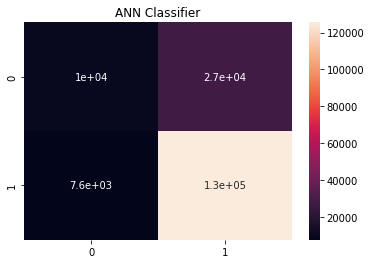

In [26]:
y_pred = ann_model.predict(x_test)
y_pred = [np.argmax(i) for i in y_pred]
ann_result = evaluate_model(y_test, y_pred, "ANN Classifier")

11907/11907 [==============================] - 29s 2ms/step - loss: 0.4320 - accuracy: 0.8043


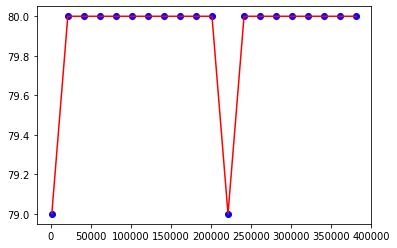

In [29]:
accuracy_scores = []
train_size = []

for limit in [i for i in range(1000, x_train.shape[0], 20000)]:
  x_train_part = x_train[:limit]
  y_train_part = y_train[:limit]

  ann_model.fit(x_train_part,to_categorical(y_train_part))
  y_pred=ann_model.predict(x_test)
  y_pred=[np.argmax(i) for i in y_pred]

  acc=accuracy_score(y_test, y_pred)
  acc = round(acc, 2) * 100

  accuracy_scores.append(acc)
  train_size.append(limit)

plt.plot(train_size, accuracy_scores, color='red')
plt.scatter(train_size, accuracy_scores, color='blue')

# Accuracy Camparsion Comparison

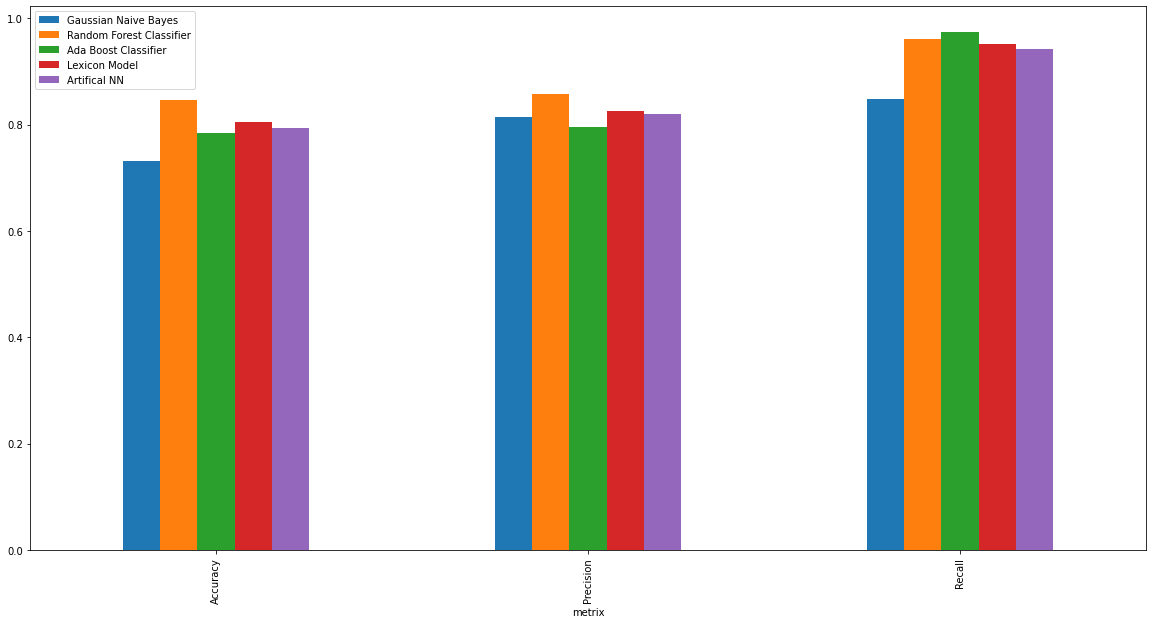

In [30]:
data = {
    'metrix': ["Accuracy", "Precision", "Recall"],
    'Gaussian Naive Bayes': gnb_result,
    'Random Forest Classifier': rfc_result,
    'Ada Boost Classifier': ada_result,
    'Lexicon Model': lbc_result,
    'Artifical NN': ann_result
    }

data = pd.DataFrame(data)
data.index = data.metrix
data.plot(kind='bar', figsize=(20,10))